TAGET: 查看获取的出租车GPS的偏移情况 \
1.从高德获取所在区域的经纬度范围\
2.将查询区域划分为若干个小区域\
3.获取每个小区域内的道路名称\
4.根据道路名称查询道路的折线信息\
5.可视化的绘制

#### Part 1 获取经纬度信息

In [181]:
import urllib.request 
from urllib import parse 
import json 
import re
import pandas as pd
# import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly
import numpy as np
from pandas import DataFrame
import math
import matplotlib.pyplot as plt

mykey=u'51cffc64fd38c249e18e2a8265ad06f9'

In [3]:
# 获取温州地区轮廓经纬度，划定矩阵
dist_Url = ('http://restapi.amap.com/v3/config/district?'
                'key={key}&keywords=温州&subdistrict=2&extensions=all')
dist_Url = parse.quote(dist_Url.format(key=mykey),safe="/:=&?#+!$,;'@()*[]")
response = urllib.request.urlopen(dist_Url)
data = response.read()

jsonData=json.loads(data)
polyline=re.split("[;\|]",jsonData['districts'][0]['polyline'])
print(polyline)

['121.074413,28.020475', '121.072726,28.020635', '121.071588,28.021384', '121.0711,28.0225', '121.071202,28.023596', '121.071832,28.026559', '121.071771,28.027411', '121.071609,28.028182', '121.07169,28.029582', '121.072239,28.030537', '121.07293,28.031065', '121.07417,28.031108', '121.075654,28.031007', '121.077198,28.030462', '121.078113,28.02888', '121.078722,28.026446', '121.078621,28.024274', '121.077604,28.022122', '121.076161,28.020924', '121.074413,28.020475', '121.043159,28.024978', '121.041968,28.025201', '121.040882,28.025614', '121.039944,28.02614', '121.039675,28.026633', '121.039631,28.027101', '121.039762,28.027525', '121.040239,28.028185', '121.040848,28.028472', '121.042073,28.028544', '121.042951,28.028434', '121.044236,28.027987', '121.044723,28.027659', '121.045009,28.027148', '121.045192,28.026187', '121.045122,28.025746', '121.044853,28.025424', '121.044314,28.025128', '121.043914,28.024989', '121.043159,28.024978', '121.054385,28.018931', '121.050729,28.019166', 

['121.074413,28.020475', '121.072726,28.020635', '121.071588,28.021384', '121.0711,28.0225', '121.071202,28.023596', '121.071832,28.026559', '121.071771,28.027411', '121.071609,28.028182', '121.07169,28.029582']

In [ ]:
max_lon=max_lat=0
min_lon=min_lat=float('inf')
for pair in polyline:
    lon,lat=pair.split(',')
    max_lon=max(max_lon,float(lon))
    max_lat=max(max_lat,float(lat))
    min_lon=min(min_lon,float(lon))
    min_lat=min(min_lat,float(lat))

#### Part 2 划分为小区域

In [120]:
#由于高德查询限制，需要将查询区域划分为小块
def generalID(column_num,row_num):
    latitude = (max_lat - min_lat)/column_num
    longitude = (max_lon - min_lon)/row_num
    polylists = []
 
    for i in range(column_num):
        left_latitude = min_lat + latitude * i
        righ_latitude = min_lat + latitude * (i+1)
        for j in range(row_num):
            temp = ""
            left_longitude = min_lon + longitude * j
            righ_longitude = min_lon + longitude * (j+1)
            temp =str(left_longitude)+','+ str(left_latitude) + '|' + str(righ_longitude)+  ','+ str(righ_latitude) 
            polylists.append(temp)
    return polylists

polylists = generalID(15, 15)

#### part 3 在每个区域内查询道路名称

In [255]:
#依次将查询结果写入文件
def get_page_road(polygon,page):
    search_url =('http://restapi.amap.com/v3/place/polygon?'
                  'key={key}&polygon={polygon}&keywords=&types=190301&offset=20&page={page}&extensions=all')
    search_url = parse.quote(search_url.format(polygon=polygon,key=mykey,page=page),safe="/:=&?#+!$,;'@()*[]")
    response = urllib.request.urlopen(search_url)
    data = response.read().decode('utf-8')
    jsonData=json.loads(data)['pois']
    ret=DataFrame({'name':[],'id':[]})
    for road in jsonData:
        if (road['cityname']=='温州市'):
            ret=ret.append({'name':road['name'],'id':road['id']},ignore_index=True) 
    return ret

roads=DataFrame({'name':[],'id':[]})
for poly in polylists:
    page = 1
    while True:
        road=get_page_road(poly,page)
        if (road.empty):
            break
        roads=roads.append(road)
        page+=1
roads.head()
roads=roads.reset_index(drop=True)
# roads=roads.drop_duplicates()
# roads.to_csv("roads.csv",index=False,sep=',',encoding="gbk")

#### part 4 根据道路名称获取道路点对

In [322]:
#根据道路名称，查询
road_list=[]
for roadname in roads['name']:
    url =('http://restapi.amap.com/v3/road/roadname?'
      'key={key}&keywords={roadname}&city=0577')
    url = parse.quote(url.format(key=mykey,roadname=roadname),safe="/:=&?#+!$,;'@()*[]")
    response = urllib.request.urlopen(url)
    data = response.read().decode('utf-8')
    jsonData=json.loads(data)
    road_list+=jsonData['roads']

In [5]:
# 存储json
# with open("roads.json","w",encoding='utf-8') as f:
#     json.dump(road_list,f,ensure_ascii=False)
# 读取json
with open("data/roads.json","r",encoding='utf-8') as f:
    road_list=json.load(f)

#### part 5 读取处理TAXI信息

In [230]:
df_taxi=pd.read_csv('data/sample_data_week/taxi/taxi-20200304.csv',engine='python',encoding='utf-8')
df_taxi.drop(df_taxi[df_taxi['LONGI']<1].index,inplace=True)
df_taxi.columns

Index(['???"PLA_NO"', 'LONGI', 'LATI', 'RUN_STATUS', 'GPS_TIME'], dtype='object')

Index(['"PLA_NO"', 'LONGI', 'LATI', 'RUN_STATUS', 'GPS_TIME'], dtype='object')

In [232]:
TaxiTrace=[]
for name,group in df_taxi.groupby('???"PLA_NO"'):
    trace=group.loc[:,['LONGI', 'LATI','GPS_TIME']].sort_values(by='GPS_TIME')
    trace=trace.loc[:,['LONGI', 'LATI']]
    x_=np.array(trace.loc[:,['LONGI']]).reshape(-1)
    y_=np.array(trace.loc[:,['LATI']]).reshape(-1)
    TaxiTrace.append((x_,y_))

In [242]:
TaxiTrace[0][0]

array([120.68328 , 120.68307 , 120.68369 , ..., 120.69826 , 120.694244,
       120.69425 ])

[(array([115.670944, 115.66965 , 115.67032 , ..., 115.68498 , 115.68498 ,
         115.68498 ]),
  array([33.37483 , 33.375378, 33.37546 , ..., 33.374924, 33.374924,
         33.374924])),...]

In [233]:
#将前部分求取的路线记录成相同格式
RoadTrace=[]
for unit in road_list:
    for roads in unit['polylines']:
        Long,Lati=[],[]
        road=roads.split(';')
        for pair in road:
            lon,lat=pair.split(',')
            Long.append(float(lon))
            Lati.append(float(lat))
        RoadTrace.append((Long,Lati))

In [234]:
# 根据数据，划定出租车所在区域，并筛选路径点区域以减少计算量
max_lon=120.7
min_lon=120.5
max_lat=28.02
min_lat=27.94

RoadTrace_fil=[]
for node in RoadTrace:
    lon=np.array(node[0])
    lat=np.array(node[1])
#     print(lon.max(),lon.min(),lat.max(),lat.min())
    if((lon.max()<min_lon) or (lon.min()>max_lon) or (lat.max()<min_lat) or (lat.max()>max_lat)):
        pass
    else:
        RoadTrace_fil.append(node) 

#### part 6 可视化路网与TAXI_GPS

In [267]:
pyplt = plotly.offline.plot 
data=[]
for road in RoadTrace_fil[0:10000]:
    lon,lat=(np.array(road[0]),np.array(road[1]))
    data.append(go.Scatter(
                            x = lon,
                            y = lat,
                            line = dict(
                                        width = 2, 
                                        color = 'rgb(0, 0, 0)')
                                     ))

In [268]:
for taxi in TaxiTrace[0:1]:
    data.append(go.Scatter(
                            x = taxi[0],
                            y = taxi[1],
                            line = dict(
                                        width = 1, 
                                        color = 'rgb(255, 0, 0)')
                                     ))
pyplt(data)

'temp-plot.html'

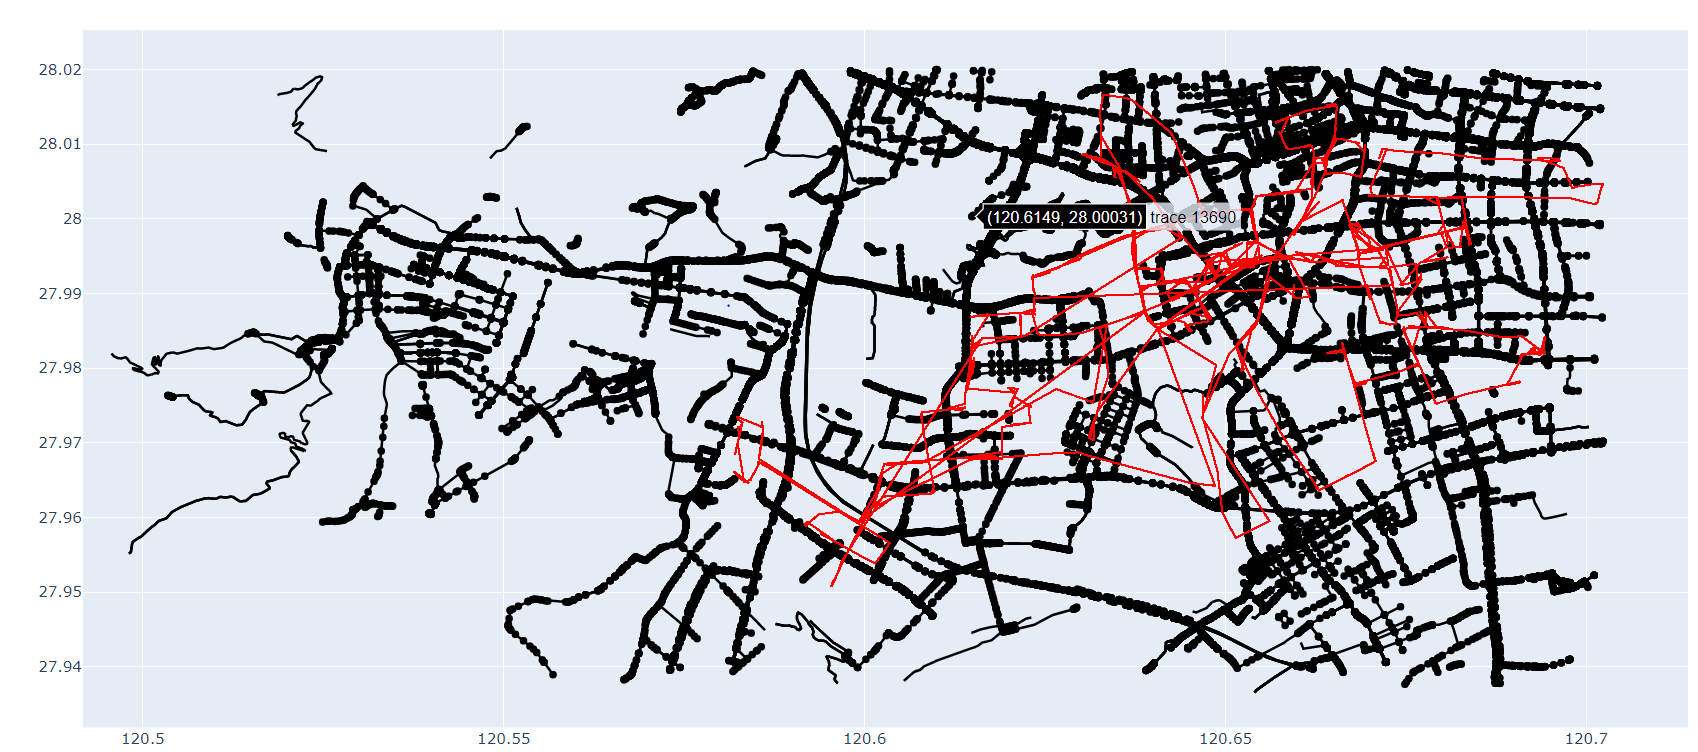

之后的工作证明GPS信息没有很多的偏移，偏移来自与坐标系的不同，高德采取的坐标系与出租车GPS位置的坐标系不同，可以通过坐标系转换修正

In [ ]:
def GCJ2WGS(lon,lat):
    a = 6378245.0 # 克拉索夫斯基椭球参数长半轴a
    ee = 0.00669342162296594323 #克拉索夫斯基椭球参数第一偏心率平方
    PI = 3.14159265358979324 # 圆周率
    # 以下为转换公式
    x = lon - 105.0
    y = lat - 35.0
    # 经度
    dLon = 300.0 + x + 2.0 * y + 0.1 * x * x + 0.1 * x * y + 0.1 * np.sqrt(abs(x));
    dLon += (20.0 * np.sin(6.0 * x * PI) + 20.0 * np.sin(2.0 * x * PI)) * 2.0 / 3.0;
    dLon += (20.0 * np.sin(x * PI) + 40.0 * np.sin(x / 3.0 * PI)) * 2.0 / 3.0;
    dLon += (150.0 * np.sin(x / 12.0 * PI) + 300.0 * np.sin(x / 30.0 * PI)) * 2.0 / 3.0;
    #纬度
    dLat = -100.0 + 2.0 * x + 3.0 * y + 0.2 * y * y + 0.1 * x * y + 0.2 * np.sqrt(abs(x));
    dLat += (20.0 * np.sin(6.0 * x * PI) + 20.0 * np.sin(2.0 * x * PI)) * 2.0 / 3.0;
    dLat += (20.0 * np.sin(y * PI) + 40.0 * np.sin(y / 3.0 * PI)) * 2.0 / 3.0;
    dLat += (160.0 * np.sin(y / 12.0 * PI) + 320 * np.sin(y * PI / 30.0)) * 2.0 / 3.0;
    radLat = lat / 180.0 * PI
    magic = np.sin(radLat)
    magic = 1 - ee * magic * magic
    sqrtMagic = np.sqrt(magic)
    dLat = (dLat * 180.0) / ((a * (1 - ee)) / (magic * sqrtMagic) * PI);
    dLon = (dLon * 180.0) / (a / sqrtMagic * np.cos(radLat) * PI);
    wgsLon = lon - dLon
    wgsLat = lat - dLat
    return wgsLon,wgsLat

In [270]:
pyplt = plotly.offline.plot 
data=[]
for road in RoadTrace_fil[0:10000]:
    lon,lat=GCJ2WGS(np.array(road[0]),np.array(road[1]))
    data.append(go.Scatter(
                            x = lon,
                            y = lat,
                            line = dict(
                                        width = 2, 
                                        color = 'rgb(0, 0, 0)')
                                     ))
for taxi in TaxiTrace[0:1]:
    data.append(go.Scatter(
                            x = taxi[0],
                            y = taxi[1],
                            line = dict(
                                        width = 1, 
                                        color = 'rgb(255, 0, 0)')
                                     ))
pyplt(data)

'temp-plot.html'

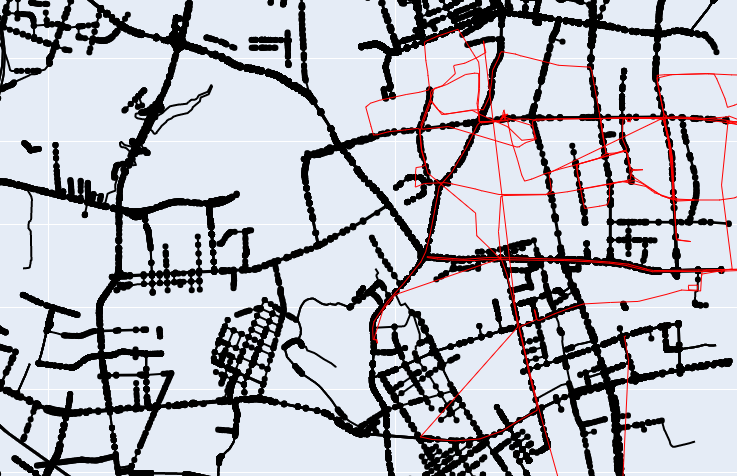
此时可以看到匹配上GPS信息

In [271]:
# RoadRef=[]
# for road in road_list:
#     lon,lat=[],[]
#     for road_poly in road['polylines']:
#         for i in road_poly.split(';'):
#             lon.append(float(i.split(',')[0]))
#             lat.append(float(i.split(',')[1]))
#     poly=GCJ2WGS(np.array(lon),np.array(lat))
#     for points in poly.T:
#         RoadRef.append({'name':road['name'],'polylon':points[0],'polylat':points[1]})
# pd.DataFrame(RoadRef).to_csv('data/RoadName.csv')